In [1]:
import json
import matplotlib
import warnings

warnings.simplefilter('ignore')
root = r"/Users/Kenneth-Aristide/anaconda3/bin/python_prog/ML/styles/bmh_matplotlibrc.json"
s = json.load(open(root))
matplotlib.rcParams.update(s)

## A Motivating Example: Linear Regression

To introduce model definition, fitting and posterior analysis, we first consider a simple Bayesian linear regression model with normal priors for the parameters. We are interested in predicting outcomes $Y$ as normally-distributed observations with an expected value $\mu$ that is a linear function of two predictor variables, $X_1$ and $X_2$.

$$\begin{aligned} 
Y  &\sim \mathcal{N}(\mu, \sigma^2) \\
\mu &= \alpha + \beta_1 X_1 + \beta_2 X_2
\end{aligned}$$

where $\alpha$ is the intercept, and $\beta_i$ is the coefficient for covariate $X_i$, while $\sigma$ represents the observation error. Since we are constructing a Bayesian model, the unknown variables in the model must be assigned a prior distribution. We choose zero-mean normal priors with variance of 100 for both regression coefficients, which corresponds to *weak* information regarding the true parameter values. We choose a half-normal distribution (normal distribution bounded at zero) as the prior for $\sigma$.

$$\begin{aligned} 
\alpha &\sim \mathcal{N}(0, 100) \\
\beta_i &\sim \mathcal{N}(0, 100) \\
\sigma &\sim \lvert\mathcal{N}(0, 1){\rvert}
\end{aligned}$$

### Generating data

We can simulate some artificial data from this model using only NumPy's `random` module, and then use PyMC3 to try to recover the corresponding parameters. We are intentionally generating the data to closely correspond the PyMC3 model structure.

In [2]:
import numpy as np

#initialize a random number generator
np.random.seed(123)

# size of the observed sample
size = 100

# True parameter value
alpha, sigma = 1, 1
beta = [1, 2.5]

#Predictor variables
X_1 = np.linspace(0, 1, size)
X_2 = np.linspace(0, .2, size)

#simulate outcome variables
Y = alpha + beta[0]*X_1 + beta[1]*X_2 + np.random.randn(size)*sigma

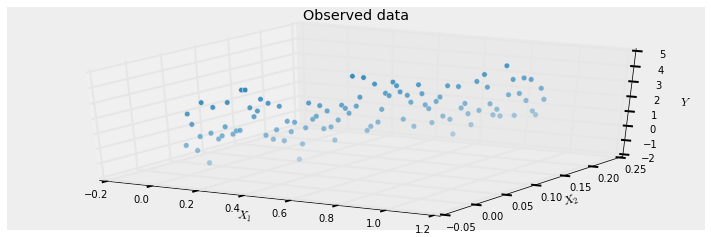

In [3]:
#Various plot to observed data
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.core.pylabtools import figsize
%matplotlib inline

figsize(12.5, 4)

colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]


# 3D Plot
fig = plt.figure()
ax_3d = fig.add_subplot(111, projection = '3d')
ax_3d.scatter(X_1, X_2, Y, s= 30, c = colors[0])
ax_3d.set_xlabel("$X_1$")
ax_3d.set_ylabel("$X_2$")
ax_3d.set_zlabel("$Y$")
ax_3d.set_title("Observed data")

#2D plot X_1, Y
#fig = plt.figure()
#ax_2d_0 = fig.add_subplot(111)
#ax_2d_0.scatter(X_1, Y, s=20, c=colors[1])
#ax_2d_0.set_xlabel("$X_1$")
#ax_2d_0.set_ylabel("$Y$")

# 2D Plot X_2, Y
#fig = plt.figure()
#ax_2d_1 = fig.add_subplot(111)
#ax_2d_1.scatter(X_2, Y, s = 20, c = colors[2])
#ax_2d_1.set_xlabel("$X_2$")
#ax_2d_1.set_ylabel("$Y$")


plt.show();
#plt.savefig("C:\\Users\\admin\\Desktop\\Python_Prog\\PyMC3\\training\\plots\\fig_0" )

In [4]:
# Model Specification
import pymc3 as pm
import scipy

## OLS
with pm.Model() as model:
    
    # Priors dor unknow model parameters
    alpha = pm.Normal("alpha", mu = 0, sd = 100)
    betas = pm.Normal("betas", mu = 0, sd = 100, shape = 2)
    std = pm.HalfNormal("std", sd = 1)
    
    # Expected value outcome
    mean = pm.Deterministic("mean", alpha + beta[0]*X_1 +  beta[1]*X_2)
    
    # Likelihood of observations
    observation = pm.Normal("obs", mu = mean, sd = std, observed = Y)

In [5]:
#MCMC
import scipy

with model:
    
    # Obtain starting value
    start = pm.find_MAP(fmin = scipy.optimize.fmin_powell)
    
    # instantiate the sampler
    step = pm.NUTS(scaling = start)
    
    #Draw 20000 posterior samples
    trace = pm.sample(20000, step = step, start = start)
    burned_trace = trace[10000:]
    

Optimization terminated successfully.
         Current function value: 171.273575
         Iterations: 3
         Function evaluations: 135


100%|██████████| 20000/20000 [00:15<00:00, 1282.29it/s]


In [6]:
# Plot the Posterior distribution and the trace of each unknow

def plot_posterior_0(samples, colors):
    figsize(12.5, 4)
    
    fig = plt.figure()
    fig.add_subplot(221)
    plt.title("Posterior distribution of $beta_0$")
    plt.hist(samples, histtype = "stepfilled", bins = 30, color = colors[0])
    
    fig.add_subplot(222)
    plt.title("Trace of $betas$")
    plt.plot(samples, c = colors[1])
    
    plt.tight_layout()
    return

def plot_posterior_1(samples, name, colors, i = 1):
    figsize(12.5, 4)
    fig = plt.figure()
    fig.add_subplot(2, 2, i)
    plt.title("Posterior distribution of ${}$".format(name))
    plt.hist(samples, histtype = "stepfilled", bins = 30, color = colors[0])
    
    fig.add_subplot(2, 2, i+1)
    plt.title("Trace of ${}$".format(name))
    plt.plot(samples,c = colors[1])
    
    plt.tight_layout()
    return
    

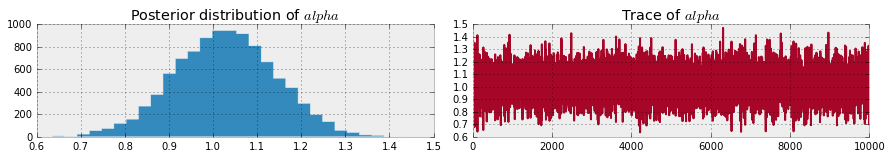

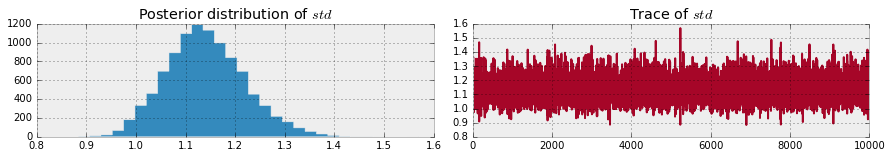

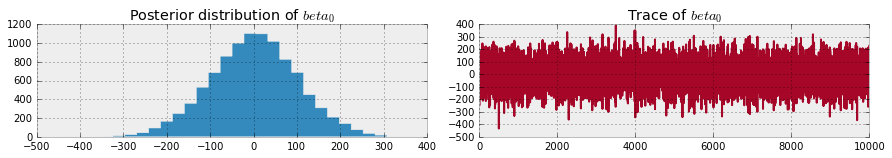

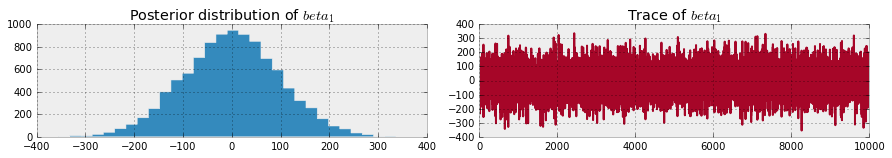

In [7]:
#Posterior
samples_alpha = burned_trace["alpha"]
samples_beta = burned_trace["betas"]
samples_std = burned_trace["std"]
samples_mean = burned_trace["mean"]

plot_posterior_1(samples_alpha, "alpha", colors, i = 1)
plot_posterior_1(samples_std, "std", colors, i = 1)
plot_posterior_1(samples_beta[:, 0], "beta_0", colors, i = 1)
plot_posterior_1(samples_beta[:, 1], "beta_1", colors, i = 1)

# Or simply type pm.traceplot(burned_trace)

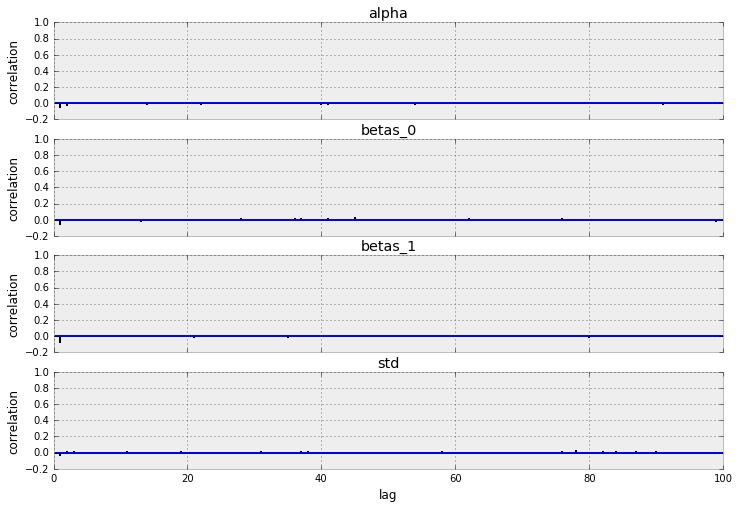

In [9]:
# Diagnostic of convergence : did the MCMC converge?
pm.plots.autocorrplot(trace = burned_trace, varnames = ["alpha", "betas", "std"]);

In [10]:
#pm.summary(burned_trace)

By default, `find_MAP` uses the Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimization algorithm to find the maximum of the log-posterior but also allows selection of other optimization algorithms from the `scipy.optimize` module. For example, below we use Powell's method to find the MAP.

It is important to note that the MAP estimate is not always reasonable, especially if the mode is at an extreme. This can be a subtle issue; with high dimensional posteriors, one can have areas of extremely high density but low total probability because the volume is very small. This will often occur in hierarchical models with the variance parameter for the random effect. If the individual group means are all the same, the posterior will have near infinite density if the scale parameter for the group means is almost zero, even though the probability of such a small scale parameter will be small since the group means must be extremely close together. 

Most techniques for finding the MAP estimate also only find a *local* optimium (which is often good enough), but can fail badly for multimodal posteriors if the different modes are meaningfully different.


#### Sampling methods

Though finding the MAP is a fast and easy way of obtaining estimates of the unknown model parameters, it is limited because there is no associated estimate of uncertainty produced with the MAP estimates. Instead, a simulation-based approach such as Markov chain Monte Carlo (MCMC) can be used to obtain a Markov chain of values that, given the satisfaction of certain conditions, are indistinguishable from samples from the posterior distribution. 

To conduct MCMC sampling to generate posterior samples in PyMC3, we specify a **step method** object that corresponds to a particular MCMC algorithm, such as Metropolis, Slice sampling, or the No-U-Turn Sampler (NUTS). PyMC3's `step_methods` submodule contains the following samplers: `NUTS`, `Metropolis`, `Slice`, `HamiltonianMC`, and `BinaryMetropolis`.


#### Gradient-based sampling methods

PyMC3 has the standard sampling algorithms like adaptive Metropolis-Hastings and adaptive slice sampling, but PyMC3's most capable step method is the No-U-Turn Sampler. NUTS is especially useful on models that have many continuous parameters, a situatiuon where other MCMC algorithms work very slowly. It takes advantage of information about where regions of higher probability are, based on the gradient of the log posterior-density. This helps it achieve dramatically faster convergence on large problems than traditional sampling methods achieve. PyMC3 relies on Theano to analytically compute model gradients via automatic differentation of the posterior density. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo. For random variables that are undifferentiable (namely, discrete variables) NUTS cannot be used, but it may still be used on the differentiable variables in a model that contains undifferentiable variables. 

NUTS requires a scaling matrix parameter, which is analogous to the variance parameter for the jump proposal distribution in Metropolis-Hastings, althrough NUTS uses it somewhat differently. The matrix gives the rough shape of the distribution so that NUTS does not make jumps that are too large in some directions and too small in other directions. It is important to set this scaling parameter to a reasonable value to facilitate efficient sampling. This is especially true for models that have many unobserved stochastic random variables or models with highly non-normal posterior distributions. Poor scaling parameters will slow down NUTS significantly, sometimes almost stopping it completely. A reasonable starting point for sampling can also be important for efficient sampling, but not as often.

Fortunately NUTS can often make good guesses for the scaling parameters. If you pass a point in parameter space (as a dictionary of variable names to parameter values, the same format as returned by `find_MAP`) to NUTS, it will look at the local curvature of the log posterior-density (the diagonal of the Hessian matrix) at that point to make a guess for a good scaling vector, which often results in a good value. The MAP estimate is often a good point to use to initiate sampling. It is also possible to supply your own vector or scaling matrix to NUTS, though this is a more advanced use. If you wish to modify a Hessian at a specific point to use as your scaling matrix or vector, you can use `find_hessian` or `find_hessian_diag`.

For our basic linear regression example in `basic_model`, we will use NUTS to sample 2000 draws from the posterior using the MAP as the starting point and scaling point. This must also be performed inside the context of the model.


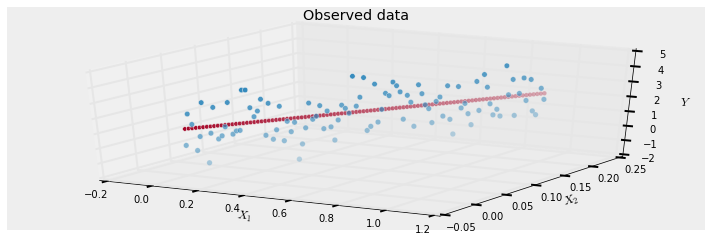

In [11]:
# 3D Plot
fig = plt.figure()
ax_3d = fig.add_subplot(111, projection = '3d')
ax_3d.scatter(X_1, X_2, Y, s= 30, c = colors[0])
ax_3d.scatter(X_1, X_2, samples_mean.mean(axis = 0), c = colors[1])
ax_3d.set_xlabel("$X_1$")
ax_3d.set_ylabel("$X_2$")
ax_3d.set_zlabel("$Y$")
ax_3d.set_title("Observed data");